In [247]:
import ast
import pickle
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler

from run1.lib.classes_ml import DataHandler
from run1.lib.directory import get_directory
from run1.lib.optuna_ml import OptunaUtil
from run1.lib.shap import ShapUtil

In [248]:
CURRENT_DIR = Path.cwd()  # Current directory of the running file
# Get data directory
directory = get_directory(CURRENT_DIR, verbose=True)
DATA_PATH = directory["DATA_PATH"]
STUDY_ML_PATH = directory["STUDY_ML_PATH"]

Code is running in a Jupyter environment.
ROOT_DIR: c:\Users\admin\Coding\research\weld-ml
DATA_DIR: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T01_af_features
DATA_PATH: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T01_af_features\S01_combined_data.xlsx
STUDY_ML_DIR: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T02_optuna
STUDY_ML_PATH: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T02_optuna\S02_combine_study.xlsx
STUDY_TABPFN_DIR: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T11_tabPFN
STUDY_TABPFN_PATH: c:\Users\admin\Coding\research\weld-ml\run1\P04_MF2\T11_tabPFN\S01_calculate_performance.xlsx


In [249]:
# Load study info
study_info = pd.read_excel(STUDY_ML_PATH)
study_info["model_params"] = study_info["model_params"].apply(ast.literal_eval)

# Load experimental data
_df = pd.read_excel(DATA_PATH)
print(f"df.shape: {_df.shape}")

df.shape: (378, 25)


In [250]:
# Select columns for features and targets
colsY = [c for c in _df.columns if re.search(r"stress_value", c)]
colsX = [c for c in _df.columns if c not in ["sample_no", "location", *colsY]]

# Select feature columns based on predefined names
colsY = [c for c in colsY if c in ["stress_value_center"]]

_dfY = _df[colsY]
_dfX = _df[colsX]
print("Selected feature columns:", colsX)
print("Selected target columns:", colsY)
print(f"dfX.shape: {_dfX.shape}")
print(f"dfY.shape: {_dfY.shape}")

Selected feature columns: ['D', 'Fx__dwell__ar_coefficient__coeff_0__k_10', 'Fx__dwell__fft_coefficient__attr_"abs"__coeff_11', 'Fx__weld__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'Fx__weld__fft_coefficient__attr_"abs"__coeff_5', 'Fx_location', 'Fy__dwell__fft_coefficient__attr_"abs"__coeff_59', 'Fy__dwell__fft_coefficient__attr_"real"__coeff_71', 'Fy__weld__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'Fy__weld__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'Fz__dwell__fft_coefficient__attr_"angle"__coeff_4', 'Fz__dwell__fft_coefficient__attr_"real"__coeff_4', 'Fz__weld__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'Fz__weld__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'Fz_location', 'Mz__dwell__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'Mz__dwell__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'R', 'W', 'position']
Selected target columns: ['stress_value_center']
dfX.shape: (378,

In [251]:
# %% Extract features and targets
_X = _dfX.values
_Y = _dfY.values
print(f"_X.shape: {_X.shape}")
print(f"_Y.shape: {_Y.shape}")

_X.shape: (378, 20)
_Y.shape: (378, 1)


In [252]:
# Select columns for features and targets
colsY = [c for c in _df.columns if re.search(r"stress_value", c)]
colsX = [c for c in _df.columns if c not in ["sample_no", "location", *colsY]]

# Select feature columns based on predefined names
colsY = [c for c in colsY if c in ["stress_value_center"]]

_dfY = _df[colsY]
_dfX = _df[colsX]
print("Selected feature columns:", colsX)
print("Selected target columns:", colsY)
print(f"dfX.shape: {_dfX.shape}")
print(f"dfY.shape: {_dfY.shape}")

Selected feature columns: ['D', 'Fx__dwell__ar_coefficient__coeff_0__k_10', 'Fx__dwell__fft_coefficient__attr_"abs"__coeff_11', 'Fx__weld__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2', 'Fx__weld__fft_coefficient__attr_"abs"__coeff_5', 'Fx_location', 'Fy__dwell__fft_coefficient__attr_"abs"__coeff_59', 'Fy__dwell__fft_coefficient__attr_"real"__coeff_71', 'Fy__weld__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0', 'Fy__weld__energy_ratio_by_chunks__num_segments_10__segment_focus_5', 'Fz__dwell__fft_coefficient__attr_"angle"__coeff_4', 'Fz__dwell__fft_coefficient__attr_"real"__coeff_4', 'Fz__weld__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"var"', 'Fz__weld__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.4', 'Fz_location', 'Mz__dwell__augmented_dickey_fuller__attr_"pvalue"__autolag_"AIC"', 'Mz__dwell__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"', 'R', 'W', 'position']
Selected target columns: ['stress_value_center']
dfX.shape: (378,

In [253]:
# Create DataHandler instance
data_handler = DataHandler(
    _X=_X,
    _Y=_Y,
    scalerX=StandardScaler(),
    scalerY=StandardScaler(),
    colsX=colsX,
    colsY=colsY,
)

In [254]:
# Get the best study info for each model based on r2_mean
study_info_best = study_info.groupby("model").apply(
    lambda df: df.sort_values("r2_mean", ascending=False).head(1), include_groups=False
)
study_info_best = study_info_best.reset_index().drop(columns=["level_1"])
study_info_best

,model,study_name,dt,n_trials,random_state,test_size,best_param,best_value,total_trial,mse_mean,mse_std,mape_mean,mape_std,r2_mean,r2_std,model_params
0,DTR,study_DTR_RS-4_TS-0_3,2026-02-03_22-53,50,4,0.3,"{'criterion': 'squared_error', 'splitter': 'ra...",-0.161086,80,0.834001,0.086591,1.901808,0.320215,0.161086,0.064964,"{'criterion': 'squared_error', 'splitter': 'ra..."
1,EN,study_EN_RS-5_TS-0_3,2026-02-03_22-53,50,5,0.3,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4...",-0.180867,80,0.800976,0.019510,11.570833,10.272896,0.180867,0.015216,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4..."
2,GBR,study_GBR_RS-4_TS-0_3,2026-02-03_22-53,50,4,0.3,"{'n_estimators': 134, 'learning_rate': 0.02748...",-0.198749,80,0.789098,0.059153,1.873684,0.394312,0.198749,0.045296,"{'n_estimators': 134, 'learning_rate': 0.02748..."
3,KNR,study_KNR_RS-5_TS-0_3,2026-02-03_22-53,50,5,0.3,"{'n_neighbors': 36, 'weights': 'distance', 'al...",-0.123633,80,0.863818,0.042421,18.967107,23.887208,0.123633,0.026001,"{'n_neighbors': 36, 'weights': 'distance', 'al..."
4,RFR,study_RFR_RS-5_TS-0_3,2026-02-03_22-53,50,5,0.3,"{'n_estimators': 60, 'max_depth': 5, 'min_samp...",-0.197709,80,0.783847,0.029774,17.449966,22.487250,0.197709,0.031403,"{'n_estimators': 60, 'max_depth': 5, 'min_samp..."
5,SVR,study_SVR_RS-5_TS-0_3,2026-02-03_22-53,50,5,0.3,"{'kernel': 'linear', 'C': 0.012708183589980318...",-0.154886,80,0.831516,0.042596,12.912057,13.302529,0.154886,0.031947,"{'kernel': 'linear', 'C': 0.012708183589980318..."
6,XGBR,study_XGBR_RS-5_TS-0_3,2026-02-03_22-53,50,5,0.3,"{'n_estimators': 229, 'max_depth': 8, 'learnin...",-0.201031,60,0.781947,0.014281,15.033675,21.623964,0.201031,0.022359,"{'n_estimators': 229, 'max_depth': 8, 'learnin..."


In [255]:
idx = 6
study = study_info_best.iloc[idx]
model = study["model"]
model_params = study["model_params"]
random_state = study["random_state"]
test_size = study["test_size"]
print(
    f"Processing study {idx + 1}/{len(study_info)}: model={model}, random_state={random_state}, test_size={test_size}"
)
data_handler.split_and_scale(random_state=random_state, test_size=test_size)
scalerX = data_handler.scalerX


Processing study 7/35: model=XGBR, random_state=5, test_size=0.3


In [256]:
with open("../T23_shap_ml/S01_shap_calc.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_ml = data["shaps"]
    infos_ml = data["infos"]

In [257]:
pd.DataFrame.from_dict(infos_ml)

,model,model_params,test_size,random_state
0,DTR,"{'criterion': 'squared_error', 'splitter': 'ra...",0.3,4
1,EN,"{'alpha': 0.03388469103413104, 'l1_ratio': 0.4...",0.3,5
2,GBR,"{'n_estimators': 134, 'learning_rate': 0.02748...",0.3,4
3,KNR,"{'n_neighbors': 36, 'weights': 'distance', 'al...",0.3,5
4,RFR,"{'n_estimators': 60, 'max_depth': 5, 'min_samp...",0.3,5
5,SVR,"{'kernel': 'linear', 'C': 0.012708183589980318...",0.3,5
6,XGBR,"{'n_estimators': 229, 'max_depth': 8, 'learnin...",0.3,5


In [258]:
shap_values_list = []

In [259]:
idxs = [ 2, 4, 6]
for idx in idxs:
    shap_values = shaps_ml[idx]["shap_values"]
    model = shaps_ml[idx]["model"]
    shap_values_list.append(shap_values)
    print(f"Model: {model}")

Model: GBR
Model: RFR
Model: XGBR


In [260]:
with open("../T24_shap_tabPFN/S02_shap_values.pkl", "rb") as f:
    data = pickle.load(f)
    shaps_tabPFN = data["shaps"]


shap_values_list.append(shaps_tabPFN)

In [261]:
# Combine SHAP values
feature_names = shap_values_list[0].feature_names

# Combine values
combined_shape_values = np.vstack([sv.values for sv in shap_values_list])
combined_shape_values.shape

# Combine base values
combined_base_values = np.concatenate([sv.base_values for sv in shap_values_list])
combined_base_values.shape

# Combine data (feature values)
combined_data = np.vstack([sv.data for sv in shap_values_list])
combined_data.shape

(1176, 20)

In [262]:
shap_values = shap.Explanation(
    values=combined_shape_values,
    base_values=combined_base_values,
    data=combined_data,
    feature_names=shap_values_list[0].feature_names,
)

In [263]:
feature_name = "Fx_location"
idx = shap_values.feature_names.index(feature_name)
df_plot = pd.DataFrame({"shap_value":shap_values.values[:, idx],  "feature_value": shap_values.data[:, idx]})
display(df_plot)

,shap_value,feature_value
0,-0.099739,-1.389219
1,-0.037059,0.197276
2,0.043101,0.356833
3,-0.102279,-0.265057
4,-0.047060,-0.188930
...,...,...
1171,0.033097,0.568181
1172,0.017026,0.114845
1173,0.027431,-0.009964
1174,-0.021283,-0.300550


In [264]:
idx = colsX.index(feature_name)
f_mean = scalerX.mean_[idx]
f_var = scalerX.var_[idx]

# Inverse transform feature values
df_plot["feature_value_inv"] = (df_plot["feature_value"] * f_var**(1/2)) + f_mean 
df_plot

,shap_value,feature_value,feature_value_inv
0,-0.099739,-1.389219,-0.149026
1,-0.037059,0.197276,-0.066923
2,0.043101,0.356833,-0.058665
3,-0.102279,-0.265057,-0.090849
4,-0.047060,-0.188930,-0.086909
...,...,...,...
1171,0.033097,0.568181,-0.047728
1172,0.017026,0.114845,-0.071189
1173,0.027431,-0.009964,-0.077648
1174,-0.021283,-0.300550,-0.092686


In [265]:
sns.set_theme(style="whitegrid", context="talk")

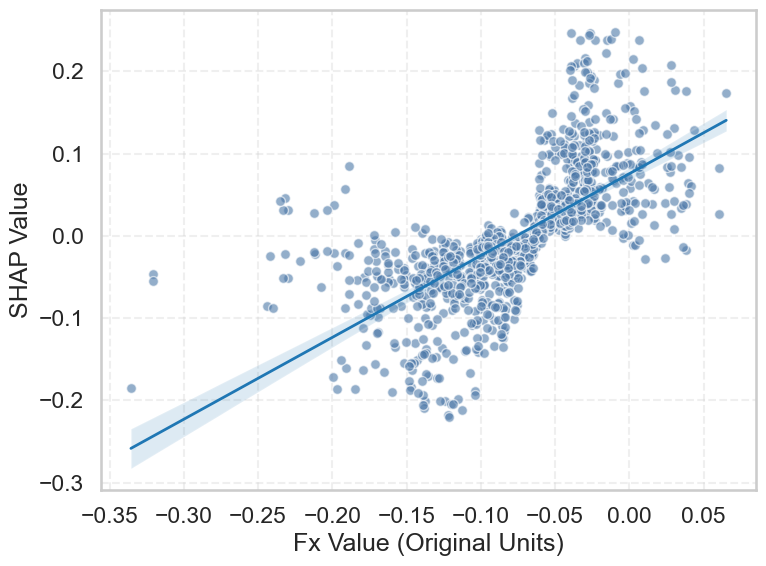

In [266]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.regplot(
    data=df_plot,
    x="feature_value_inv",
    y="shap_value",
    scatter_kws={"alpha": 0.6, "s": 50, "edgecolor": "white"},
    line_kws={"color": "#1f77b4", "linewidth": 2},
    color="#4c78a8",
)
ax.set_xlabel("Fx Value (Original Units)")
ax.set_ylabel("SHAP Value")
ax.grid(True, which="major", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("shap_fx_location.png", dpi=300, bbox_inches="tight")

In [267]:
feature_name = "Fz_location"
idx = shap_values.feature_names.index(feature_name)
df_plot = pd.DataFrame({"shap_value":shap_values.values[:, idx],  "feature_value": shap_values.data[:, idx]})
display(df_plot)

,shap_value,feature_value
0,0.017974,-0.555071
1,-0.012969,0.517862
2,0.021112,1.204769
3,0.007305,-0.673679
4,0.005552,-0.303432
...,...,...
1171,-0.034194,1.524944
1172,-0.004269,-0.397477
1173,0.014709,-0.392532
1174,0.016352,-0.085165


In [268]:
idx = colsX.index(feature_name)
f_mean = scalerX.mean_[idx]
f_var = scalerX.var_[idx]

# Inverse transform feature values
df_plot["feature_value_inv"] = (df_plot["feature_value"] * f_var**(1/2)) + f_mean 
df_plot

,shap_value,feature_value,feature_value_inv
0,0.017974,-0.555071,1.217479
1,-0.012969,0.517862,1.586251
2,0.021112,1.204769,1.822344
3,0.007305,-0.673679,1.176713
4,0.005552,-0.303432,1.303969
...,...,...,...
1171,-0.034194,1.524944,1.932390
1172,-0.004269,-0.397477,1.271645
1173,0.014709,-0.392532,1.273345
1174,0.016352,-0.085165,1.378988


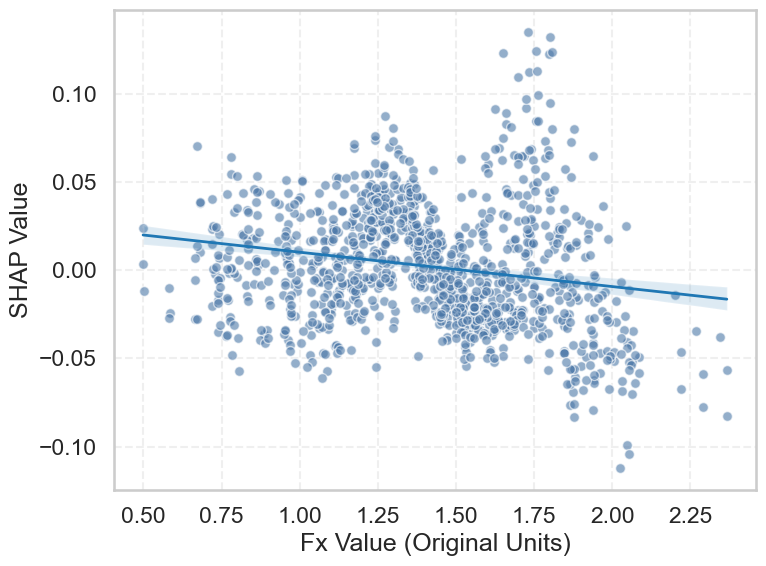

In [269]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.regplot(
    data=df_plot,
    x="feature_value_inv",
    y="shap_value",
    scatter_kws={"alpha": 0.6, "s": 50, "edgecolor": "white"},
    line_kws={"color": "#1f77b4", "linewidth": 2},
    color="#4c78a8",
)
ax.set_xlabel("Fx Value (Original Units)")
ax.set_ylabel("SHAP Value")
ax.grid(True, which="major", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("shap_fz_location.png", dpi=300, bbox_inches="tight")